# 1. Imports & Setup

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ML & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import re
import os
import random

2025-11-25 00:38:12.441826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 00:38:12.548698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set Random Seed

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 2. Load Dataset

In [5]:
# Load spam.csv safely
df = pd.read_csv("spam.csv", encoding="latin-1")

# Select only useful columns
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3. Basic EDA

In [7]:
print("Dataset shape:", df.shape)
print(df['label'].value_counts())

Dataset shape: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


In [8]:
# Message lengths
df['msg_len'] = df['text'].astype(str).apply(len)
display(df.describe(include='all'))

,label,text,msg_len
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


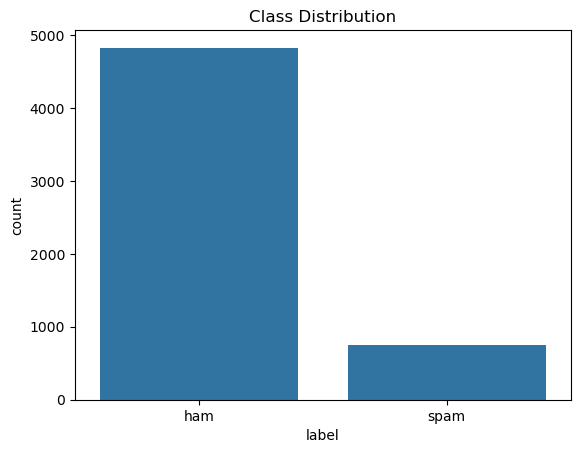

In [9]:
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()

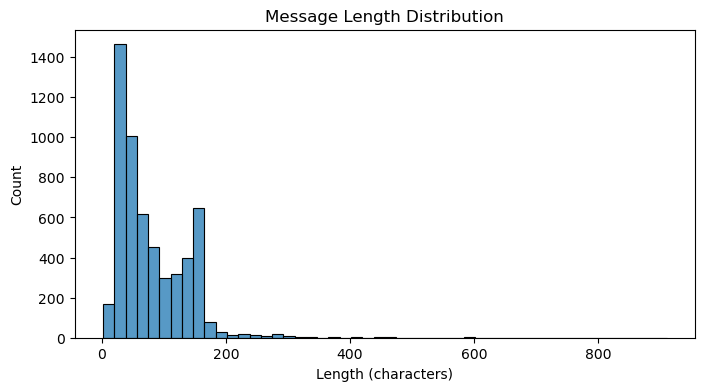

In [10]:
# Message length distribution
plt.figure(figsize=(8,4))
sns.histplot(df['msg_len'], bins=50)
plt.title('Message Length Distribution')
plt.xlabel('Length (characters)')
plt.show()

In [11]:
# Show sample messages
print("\nSample ham messages:\n", df[df['label']=='ham']['text'].sample(3, random_state=SEED).tolist())
print("\nSample spam messages:\n", df[df['label']=='spam']['text'].sample(3, random_state=SEED).tolist())


Sample ham messages:
 ['I am late,so call you tomorrow morning.take care sweet dreams....u and me...ummifying...bye.', 'U r too much close to my heart. If u go away i will be shattered. Plz stay with me.', 'Wait  &lt;#&gt;  min..']

Sample spam messages:
 ['Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804', 'This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate ', 'Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just å£1.50 per wk 2 opt out send STOP 08452810071 16']


# 4. Preprocessing

## Text Cleaning + Label Encoding

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"\d{10,}", " PHONE ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['cleaned'] = df['text'].apply(clean_text)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [24]:
df.head()

,label,text,msg_len,cleaned,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...,0


# 5. Train–Test Split

In [27]:
X = df['cleaned']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 4457 Test size: 1115


# 6. Tokenization + Padding

In [30]:
vocab_size = 20000
max_len = 120
embedding_dim = 64

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len)

X_train_pad.shape, X_test_pad.shape

print("Vocab size (tokenizer):", min(vocab_size, len(tokenizer.word_index)+1))
print("Example sequence (first train message):", X_train_seq[0][:20])
print("Padded shape:", X_train_pad.shape)

Vocab size (tokenizer): 7415
Example sequence (first train message): [77, 21, 326, 126, 1231]
Padded shape: (4457, 120)


# 7. MODEL 1 - SimpleRNN

## Build SimpleRNN

In [34]:
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),   # removed deprecated input_length
    SimpleRNN(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

rnn_model.build(input_shape=(None, max_len))
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,321 (4.91 MB)

 Trainable params: 1,288,321 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

## Train SimpleRNN

In [37]:
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9041 - loss: 0.2926 - val_accuracy: 0.9652 - val_loss: 0.1137
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9860 - loss: 0.0572 - val_accuracy: 0.9798 - val_loss: 0.0580
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9955 - loss: 0.0208 - val_accuracy: 0.9865 - val_loss: 0.0564
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.9832 - val_loss: 0.0699
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9865 - val_loss: 0.0697
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9854 - val_loss: 0.0802
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9832 - val_loss: 0.0878
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 1.0000 - loss: 7.4556e-04 - val_

## Evaluate SimpleRNN

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
SimpleRNN Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



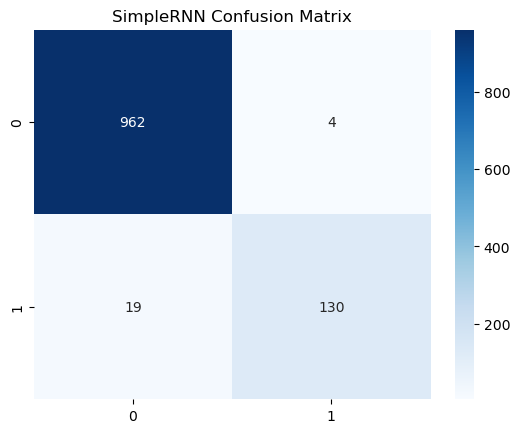

In [41]:
y_pred_rnn_prob = rnn_model.predict(X_test_pad)
y_pred_rnn = (y_pred_rnn_prob > 0.5).astype(int)

print("SimpleRNN Results:")
print(classification_report(y_test, y_pred_rnn))

cm = confusion_matrix(y_test, y_pred_rnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("SimpleRNN Confusion Matrix")
plt.show()

# 8. MODEL 2 - LSTM

## Build LSTM

In [45]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,089 (5.01 MB)

 Trainable params: 1,313,089 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM

In [48]:
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9259 - loss: 0.2259 - val_accuracy: 0.9697 - val_loss: 0.0900
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9879 - loss: 0.0470 - val_accuracy: 0.9854 - val_loss: 0.0537
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9947 - loss: 0.0189 - val_accuracy: 0.9854 - val_loss: 0.0542
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.9989 - loss: 0.0076 - val_accuracy: 0.9877 - val_loss: 0.0521
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9994 - loss: 0.0041 - val_accuracy: 0.9865 - val_loss: 0.0651
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9843 - val_loss: 0.0844
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 1.0000 - loss: 5.4546e-04 - val_accuracy: 0.9843 - val_loss: 0.0882
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 1.0000 - loss

## Evaluate LSTM

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
LSTM Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



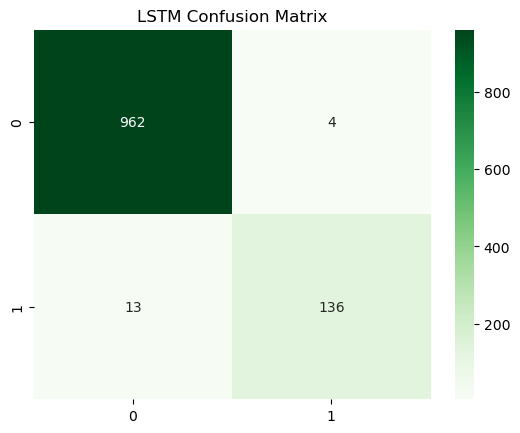

In [51]:
y_pred_lstm_prob = lstm_model.predict(X_test_pad)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)

print("LSTM Results:")
print(classification_report(y_test, y_pred_lstm))

cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("LSTM Confusion Matrix")
plt.show()

## Evaluate LSTM  ROC

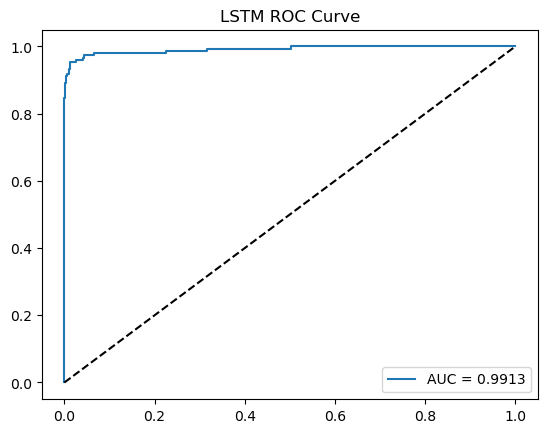

In [54]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("LSTM ROC Curve")
plt.legend()
plt.show()

# 9. MODEL 3 - BiLSTM

## Build BiLSTM Model

In [58]:
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

bilstm_model.build(input_shape=(None, max_len))
bilstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,177 (5.14 MB)

 Trainable params: 1,346,177 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

## Train BiLSTM Model

In [61]:
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.9189 - loss: 0.2354 - val_accuracy: 0.9798 - val_loss: 0.0762
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9882 - loss: 0.0435 - val_accuracy: 0.9865 - val_loss: 0.0533
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9952 - loss: 0.0188 - val_accuracy: 0.9877 - val_loss: 0.0510
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9989 - loss: 0.0062 - val_accuracy: 0.9865 - val_loss: 0.0566
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9877 - val_loss: 0.0607
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9843 - val_loss: 0.0704
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9997 - loss: 8.4632e-04 - val_accuracy: 0.9877 - val_loss: 0.0759
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 1.0000 - loss: 

## Evaluate BiLSTM

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
BiLSTM Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



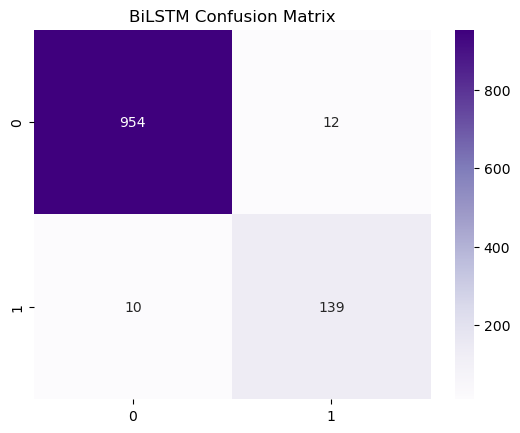

In [64]:
y_pred_bilstm_prob = bilstm_model.predict(X_test_pad)
y_pred_bilstm = (y_pred_bilstm_prob > 0.5).astype(int)

print("BiLSTM Results:")
print(classification_report(y_test, y_pred_bilstm))

cm = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("BiLSTM Confusion Matrix")
plt.show()

# Accuracy Curve (RNN vs LSTM vs BiLSTM)

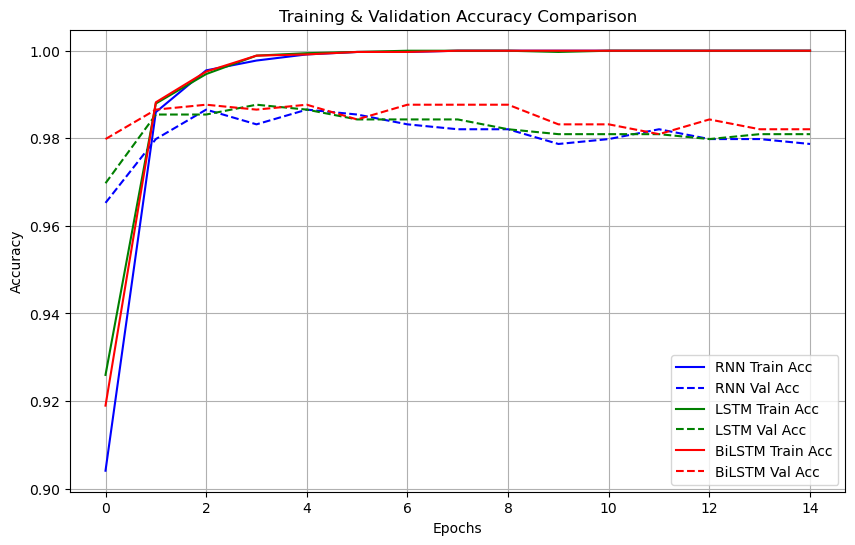

In [67]:
plt.figure(figsize=(10,6))

# SimpleRNN
plt.plot(history_rnn.history['accuracy'], label='RNN Train Acc', linestyle='-', color='blue')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val Acc', linestyle='--', color='blue')

# LSTM
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Acc', linestyle='-', color='green')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Acc', linestyle='--', color='green')

# BiLSTM
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Train Acc', linestyle='-', color='red')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Val Acc', linestyle='--', color='red')

plt.title("Training & Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Curve (RNN vs LSTM vs BiLSTM)

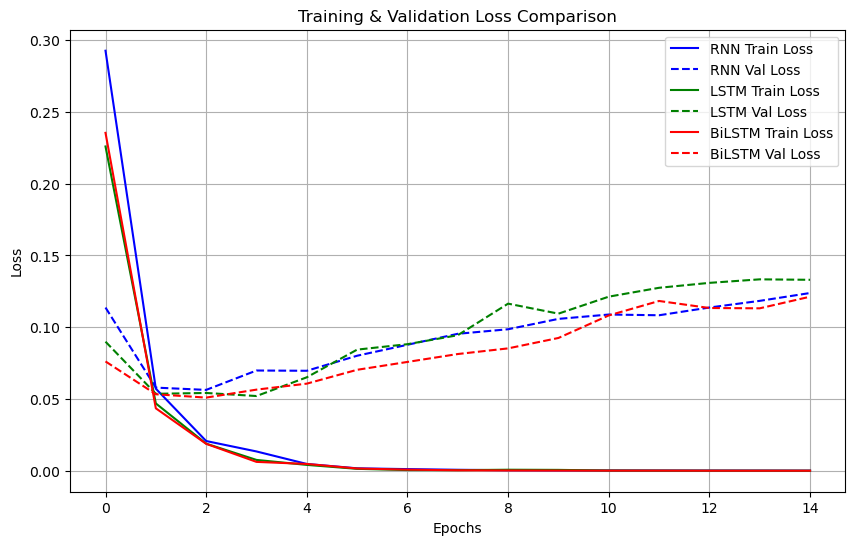

In [70]:
plt.figure(figsize=(10,6))

# SimpleRNN
plt.plot(history_rnn.history['loss'], label='RNN Train Loss', linestyle='-', color='blue')
plt.plot(history_rnn.history['val_loss'], label='RNN Val Loss', linestyle='--', color='blue')

# LSTM
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss', linestyle='-', color='green')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', linestyle='--', color='green')

# BiLSTM
plt.plot(history_bilstm.history['loss'], label='BiLSTM Train Loss', linestyle='-', color='red')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Val Loss', linestyle='--', color='red')

plt.title("Training & Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 10 Comparison Table

In [73]:
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Accuracy": report["accuracy"],
        "Precision (spam)": report["1"]["precision"],
        "Recall (spam)": report["1"]["recall"],
        "F1-score (spam)": report["1"]["f1-score"]
    }

metrics_rnn = get_metrics(y_test, y_pred_rnn)
metrics_lstm = get_metrics(y_test, y_pred_lstm)
metrics_bilstm = get_metrics(y_test, y_pred_bilstm)

results = pd.DataFrame([
    ["SimpleRNN"] + list(metrics_rnn.values()),
    ["LSTM"] + list(metrics_lstm.values()),
    ["BiLSTM"] + list(metrics_bilstm.values())
], columns=["Model", "Accuracy", "Precision (spam)", "Recall (spam)", "F1-score (spam)"])

results

,Model,Accuracy,Precision (spam),Recall (spam),F1-score (spam)
0,SimpleRNN,0.979372,0.970149,0.872483,0.918728
1,LSTM,0.984753,0.971429,0.912752,0.941176
2,BiLSTM,0.980269,0.920530,0.932886,0.926667


## 11. Saved All Models

In [76]:
import os
os.makedirs("models", exist_ok=True)

rnn_model.save("models/simple_rnn_model.h5")
lstm_model.save("models/lstm_model.h5")
bilstm_model.save("models/bilstm_model.h5")

print("Model saved successfully!")

Model saved successfully!


In [78]:
import pickle

with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!
